In [50]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Параметры

In [51]:
lmbd = 1e-4
phi_analytcal = lambda t, x, y: math.cos(math.pi * x) * math.sin(5 * math.pi*y) * math.exp(-50*(math.pi**2)*lmbd*t)
#начальные условия
phi_0x = lambda t, y: math.sin(5 * math.pi * y) * math.exp(-50 * (math.pi**2) * lmbd * t)
phi_1x = lambda t, y: -math.sin(5 * math.pi * y) * math.exp(-50 * (math.pi**2)*lmbd*t)

### Метод Гаусса Зейделя

In [52]:
def Gauss_Seidel(A, b, eps):
    x = np.zeros(len(A))  
    stop = False
    while not stop:
        x_new = np.copy(x)
        for i in range(len(A)):
            s1 = sum(A[i][j] * x_new[j] for j in range(i))
            s2 = sum(A[i][j] * x[j] for j in range(i + 1, len(A)))
            x_new[i] = (b[i] - s1 - s2) / A[i][i]

        stop = np.linalg.norm(x_new - x) <= eps
        x = x_new
    return x

### Решение двумерного уравнения теплопроводности

In [53]:
def solve(N, Nx, Ny):
    #сетки
    t, tau = np.linspace(0, 1, N + 1, retstep = True)
    x, hx = np.linspace(0, 1, Nx + 1, retstep = True)
    y, hy = np.linspace(0, 1, Ny + 1, retstep = True)
    phi = np.zeros([N + 1, Nx + 1, Ny + 1])
    eps = 1e-4
    for i in range(Nx + 1):
        for j in range(Ny + 1):
            phi[0, i, j] = math.cos(math.pi * x[i]) * math.sin(5 * math.pi * y[j]) #нулевой слой по времени
    phi[:, 0, :] = [[phi_0x(tn, yn) for yn in y] for tn in t]
    phi[:, Nx, :] = [[phi_1x(tn, yn) for yn in y] for tn in t]

    #коеффициенты
    a = (-50*lmbd/(hx**2)) - (2*lmbd/(hy**2)) - (1/tau)
    b = lmbd/(hy**2)
    c = 25*lmbd/(hx**2)

    a2 = [0] + [c for m in range(1, Nx)]
    a1 = [0] + [b for m in range(1, Nx)]
    a0 = [1] + [a for m in range(1, Nx)] + [1]
    a_1 = [b for m in range(1, Nx)] + [0]
    a_2 = [c for m in range(1, Nx)] + [0]

    #матрицы для метода ГЗ
    A0 = np.diag(a0)
    A1 = np.diag(a1, k=1)
    A_1 = np.diag(a_1, k=-1)
    A2 = np.diag(a2, k=1)
    A_2 = np.diag(a_2, k=-1)
    A11 = A0 + A1 + A_1 
    A22 = A0 + A2 + A_2 

    #цикл по времени
    for n in range(N):
        if n % 2 == 0:
            for j in range(1, Ny):
                d = [phi_0x(t[n+1], y[j])] + [-(phi[n, i, j]/tau)-(b*phi[n+1, i, j-1])-(b*phi[n, i, j+1]) for i in range(1, Nx)] + [phi_1x(t[n+1], y[j])]
                phi[n+1, :, j] = Gauss_Seidel(A22, d, eps) #прогонка 1
        else:
            for i in range(1, Nx):
                d = [0] + [-(phi[n, i, j]/tau)-(c*phi[n+1, i-1, j])-(c*phi[n, i+1, j]) for j in range(1, Ny)] + [0]
                phi[n+1, i, :] = Gauss_Seidel(A11, d, eps) #прогонка 2
                
    max_error = 0
    for l in range(Nx + 1):
        for m in range(Ny + 1):
            max_error = max(max_error, abs(phi_analytcal(t[-1], x[l], y[m]) - phi[-1, l, m]))
    
    return max_error

### График

In [60]:
steps = [10,20,30,40,50]
errors_list = []
for s in steps:
    errors_list.append(solve(s*s,s,s))

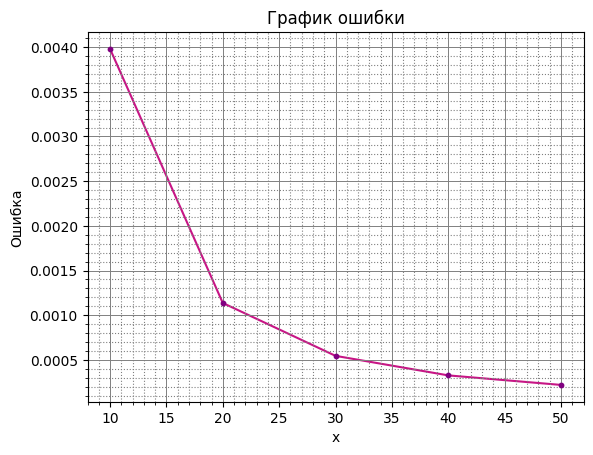

In [62]:
plt.plot(steps,errors_list, color = 'mediumvioletred', zorder=1)
plt.scatter(steps,errors_list, color = 'purple', s = 10, zorder=2)
plt.minorticks_on()
plt.grid(which='major',
            color = 'grey', 
            linewidth = 0.7)
plt.grid(which='minor', 
            color = 'grey', 
            linestyle = ':')
plt.title('График ошибки')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.savefig('График_ошибки.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


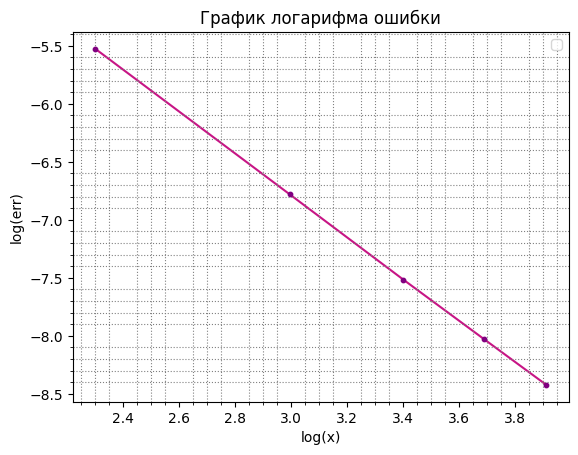

In [65]:
x = np.log([10,20,30,40,50])
y = np.log(errors_list)
plt.title('График логарифма ошибки')
plt.plot(x,y, color = 'mediumvioletred', zorder=1)
plt.scatter(x,y, color = 'purple', s = 10, zorder=2)
plt.minorticks_on()
plt.xlabel('log(x)')
plt.ylabel('log(err)')
plt.grid(which='major',
            color = 'grey', 
            linewidth = 0.7)
plt.grid(which='minor', 
            color = 'grey', 
            linestyle = ':')
plt.legend()
plt.grid()
plt.savefig('График_ошибки_log.png')